##### [warning! If you run inside binder, do not forget to download. Your session will end in ~1h]

# This tutorial is will bring you through your first deep reinforcement learning model


* Seaquest game as an example
* Training a simple lasagne neural network for Q_learning objective


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
#global params.

#game title. full list of games = http://yavar.naddaf.name/ale/list_of_current_games.html
GAME="space_invaders"

#game image will be resized from (210,160) to your image_size. 
#You may want a bigger image for your homework assignment IF you want a larger NN
IMAGE_W,IMAGE_H = IMAGE_SIZE =(105,80)

#number of parallel agents and batch sequence length (frames)
#For large scale training you may need more agents or experience replay for stability
N_AGENTS = 10
SEQ_LENGTH = 5

In [4]:
from __future__ import print_function 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS="floatX=float32"

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


env: THEANO_FLAGS="floatX=float32"


In [6]:
import Atari

ImportError: No module named 'Atari'

In [5]:
from env import Atari

#creating a game
atari = Atari(GAME,image_size=IMAGE_SIZE) 

action_names = np.array(atari.get_action_meanings())

obs = atari.step(0)[0]

plt.imshow(obs,interpolation='none')

ImportError: No module named 'env'

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [4]:
import lasagne

In [8]:
from lasagne.layers import InputLayer, DimshuffleLayer

#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,IMAGE_W,IMAGE_H,3))

#reshape to [sample, color, x, y] to allow for convolutional layers to work correctly
observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))




In [9]:
from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout

#main neural network body
#e.g. 
layer1 = Conv2DLayer(observation_reshape, 16, filter_size=(8,8),stride=(4,4), name='layer1')
layer2 = Conv2DLayer(layer1, 16, filter_size=(8,8),stride=(4,4), name='layer2')
layer3 = DenseLayer(layer2, 100,nonlinearity=lasagne.nonlinearities.tanh, name='layer3')

# <build a DQN>

#please set this to your last layer for convenience
last_layer = layer3

In [10]:
#a layer that predicts Qvalues for all actions.
# Just adense layer with corresponding number of units and no nonlinearity (lasagne.nonlinearity.linear)
n_actions = atari.action_space.n
qvalues_layer = DenseLayer(last_layer, n_actions, nonlinearity=None)

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))


##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [11]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=qvalues_layer,
              action_layers=action_layer)


In [12]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[layer1.W, layer1.b, layer2.W, layer2.b, layer3.W, layer3.b, W, b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [17]:
from pool import AtariGamePool

pool = AtariGamePool(agent,GAME, N_AGENTS,image_size=IMAGE_SIZE)


In [18]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log])
print(reward_log)

[['RIGHTFIRE' 'LEFT' 'RIGHT' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE'
  'RIGHTFIRE']
 ['RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'NOOP' 'RIGHTFIRE'
  'RIGHT']
 ['RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE'
  'RIGHTFIRE']
 ['RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE'
  'RIGHTFIRE']
 ['RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE'
  'RIGHT']
 ['RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE'
  'RIGHTFIRE']
 ['RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE'
  'RIGHTFIRE']
 ['RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE'
  'RIGHTFIRE']
 ['RIGHTFIRE' 'FIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE'
  'RIGHTFIRE']
 ['RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE' 'RIGHTFIRE'
  'RIGHTFIRE']]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0

In [19]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [20]:
#get agent's Qvalues obtained via experience replay.

#This is an "environment" that replays all stored sessions.
replay = pool.experience_replay

#To only sample several random sessions, try
#replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)


In [21]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions,
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [22]:
# Compute weight updates. Replace with any optimizer you want
updates = lasagne.updates.adam(loss,weights)

In [23]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [15]:
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2016-10-19 08:30:14,561] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 08:30:14,562] Creating monitor directory ./records
[2016-10-19 08:30:14,604] Starting new video recorder writing to /home/main/notebooks/records/openaigym.video.0.13.video000000.mp4
[2016-10-19 08:30:36,488] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/main/notebooks/records')


Episode finished after 1752 timesteps with reward=295.0


In [16]:
from IPython.display import HTML

video_path = "./records/openaigym.video.0.13.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Training loop

In [25]:
def get_epsilon(epoch_counter):
    """
    a function which outputs current epsilon for e-greedy exploration given training iteration.
    """
    # <implement me!>
    return 0.05 + 0.45*np.exp(-epoch_counter/ 1000.)

In [26]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

iter=10	epsilon=0.496
iter=20	epsilon=0.491
iter=30	epsilon=0.487
iter=40	epsilon=0.482
iter=50	epsilon=0.478
iter=60	epsilon=0.474
iter=70	epsilon=0.470
iter=80	epsilon=0.465
iter=90	epsilon=0.461


[2016-10-19 08:42:48,052] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 08:42:48,054] Clearing 4 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.457


[2016-10-19 08:42:58,337] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/main/notebooks/records')


Episode finished after 956 timesteps with reward=125.0


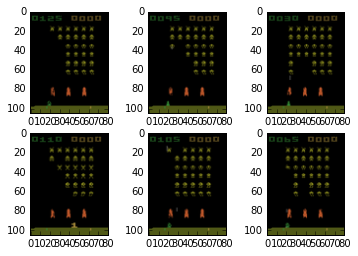

iter=110	epsilon=0.453
iter=120	epsilon=0.449
iter=130	epsilon=0.445
iter=140	epsilon=0.441
iter=150	epsilon=0.437
iter=160	epsilon=0.433
iter=170	epsilon=0.430
iter=180	epsilon=0.426
iter=190	epsilon=0.422


[2016-10-19 08:45:06,202] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 08:45:06,206] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.418


[2016-10-19 08:45:17,495] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/main/notebooks/records')


Episode finished after 602 timesteps with reward=95.0


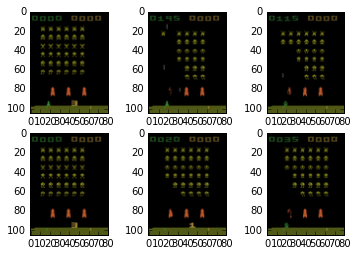

iter=210	epsilon=0.415
iter=220	epsilon=0.411
iter=230	epsilon=0.408
iter=240	epsilon=0.404
iter=250	epsilon=0.400
iter=260	epsilon=0.397
iter=270	epsilon=0.394
iter=280	epsilon=0.390
iter=290	epsilon=0.387


[2016-10-19 08:47:24,421] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 08:47:24,423] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.383


[2016-10-19 08:47:38,618] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/main/notebooks/records')


Episode finished after 1071 timesteps with reward=110.0


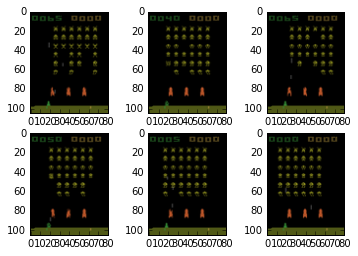

iter=310	epsilon=0.380
iter=320	epsilon=0.377
iter=330	epsilon=0.374
iter=340	epsilon=0.370
iter=350	epsilon=0.367
iter=360	epsilon=0.364
iter=370	epsilon=0.361
iter=380	epsilon=0.358
iter=390	epsilon=0.355


[2016-10-19 08:49:40,527] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 08:49:40,529] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.352


[2016-10-19 08:49:52,138] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/main/notebooks/records')


Episode finished after 947 timesteps with reward=50.0


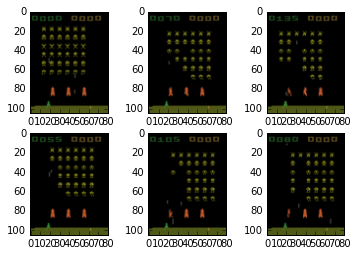

iter=410	epsilon=0.349
iter=420	epsilon=0.346
iter=430	epsilon=0.343
iter=440	epsilon=0.340
iter=450	epsilon=0.337
iter=460	epsilon=0.334


KeyboardInterrupt: 

In [27]:

#the loop may take eons to finish.
#consider interrupting early.
for i in xrange(10**10):    
    
    
    #train
    pool.update(SEQ_LENGTH)
    loss = train_step()
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = get_epsilon(epoch_counter)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,current_epsilon))
    
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
        
        plt.title("random frames")
        for i in range(min((len(pool.games),6))):
            plt.subplot(2,3,i+1)
            plt.imshow(pool.games[i].get_observation())
        plt.show()

    
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

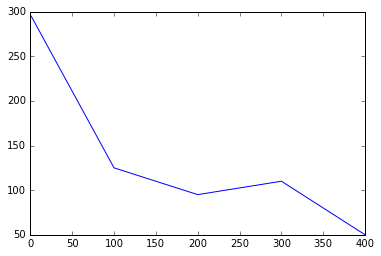

In [28]:
plt.plot(*zip(*sorted(list(rewards.items()),key=lambda p:p[0])))
    

In [30]:
rw = pool.evaluate(n_games=1,save_path="./records",record_video=True)
print("mean session score=%f.5"%rw)

[2016-10-19 08:53:32,832] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-19 08:53:32,834] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-10-19 08:53:32,897] Starting new video recorder writing to /home/main/notebooks/records/openaigym.video.6.13.video000000.mp4
[2016-10-19 08:53:54,690] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/main/notebooks/records')


Episode finished after 1207 timesteps with reward=155.0
mean session score=155.000000.5


In [31]:
from IPython.display import HTML

#select the one you want
video_path= "./records/openaigym.video.6.13.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Part II. Pre-trained net.

To speed up training, consider using the pre-trained network body and only fine-tuning the qValues layers.

Below you can find a function that loads such pre-trained network. You can use it to initialize the Q-network body.

It may make sense to not train the pre-trained part of body for a few iterations.


In [ ]:
from agentnet.utils.persistence import save,load
def build_pretrained_spaceinvaders(observation_reshape):
    """ a smaller version of DQN pre-trained for ~2 hours on GPU """
    assert tuple(observation_reshape.output_shape) == (None, 3, 105, 80)
    
    #main neural network body
    conv0 = Conv2DLayer(observation_reshape,16,filter_size=(8,8),stride=(4,4),name='conv0')
    conv1 = Conv2DLayer(conv0,32,filter_size=(4,4),stride=(2,2),name='conv1')
    dense0 = DenseLayer(conv1,256,name='dense',nonlinearity=lasagne.nonlinearities.tanh)
    
    load(dense0,"./spaceinvaders_dqn_body_small.pcl")
    return dense0

# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for info?
* [lasagne doc](http://lasagne.readthedocs.io/en/latest/)
* [agentnet doc](http://agentnet.readthedocs.io/en/latest/)
* [gym homepage](http://gym.openai.com/)


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__